In [3]:
!pip install torchvision pandas matplotlib tqdm

  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 12.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 1.4 MB/s eta 0:00:00ta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.7 MB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.9 MB/s eta 0:00:00
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzda

In [7]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageOps

import ast

In [8]:
!pip show torchvision

Name: torchvision
Version: 0.17.2
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /Users/ganna_22/Documents/Jupyter/WaterMeters/.venv/lib/python3.12/site-packages
Requires: numpy, pillow, torch
Required-by: 


In [9]:
# TRAIN_MODE set to True if model already trained, False for inference
TRAIN_MODE = True

# Dataset Location
IMG_DIR_PATH = 'WaterMeters_squared/images/'
ANNOTATIONS_CSV_PATH = 'WaterMeters_squared/data.csv'
ANNOTATIONS_XLSX_PATH = 'WaterMeters_orig/water_meters_markup.xlsx'
MODEL_PATH = 'models' #### TODO: put the right path when TRAIN_MODE = False

#Resize SIZE
SIZE = 400

# PYTORCH parameters
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 8
NB_EPOCHS = 10
NB_ITERATION = 1

In [30]:
new_images = set(os.listdir('WaterMeters_new')).difference(set(os.listdir(IMG_DIR_PATH)))

{'0ded7448db25761a3465e53879350ffc.jpg',
 '1-3.jpg',
 '111.png',
 '1701858090475.jpg',
 '1701858090487.jpg',
 '1701858090496.jpg',
 '1708094850150.jpg',
 '2024-02-19 14.38.07.jpg',
 '222.png',
 '2СЃС‡_РѕС€РёР±_Р·Р°Рї.png',
 '3 Р\x98РЅС‚РµСЂРЅР°С†РёРѕРЅР°Р»Р° 49-20.jpg',
 '325.jpg',
 '39news2.png',
 '39news2_res.png',
 '623cf75b877f30d305ec7c2ef8766fba.jpg',
 '933750x0.jpg',
 'IMG_4873.jpg',
 'IMG_4874.jpg',
 'IMG_4875.jpg',
 'IMG_4876.jpg',
 'IMG_5064.jpg',
 'IMG_5066.jpg',
 'IMG_5067.jpg',
 'IMG_5292.jpg',
 'IMG_5293.jpg',
 'IMG_5609.jpg',
 'IMG_5610.jpg',
 'IMG_5611.jpg',
 'IMG_5855.jpg',
 'IMG_5856.jpg',
 'IMG_6017.jpg',
 'IMG_6018.jpg',
 'IMG_6067.jpg',
 'IMG_6068.jpg',
 'IMG_6069 (1).jpg',
 'IMG_6069.jpg',
 'IMG_6070.jpg',
 'IMG_6071.jpg',
 'PHOTO-2024-03-07-13-37-03.jpg',
 'PHOTO-2024-03-07-13-37-20.jpg',
 'file..png',
 'file1..png',
 'file2..png',
 'image-28-02-24-12-38-1.jpeg',
 'image-28-02-24-12-38-2.jpeg',
 'image-28-02-24-12-38-3.jpeg',
 'image-28-02-24-12-38.jpeg',
 'p

In [27]:
for item in os.listdir('WaterMeters_new'):
    if item not in new_images:
        os.remove(os.path.join('WaterMeters_new', item))

In [4]:
#first create a dictionnary linking index to image name
# id values goes from 1 to 1244, I reframed that to have id from 0 to 1243.

INT_TO_NAME = {}
for dirname, _, filenames in os.walk(IMG_DIR_PATH):
    for split, filename in enumerate(filenames):
        # split = filename.split("_")
        # INT_TO_NAME[int(split[1])-1] = filename

        INT_TO_NAME[split] = filename


        # do it once for correct orientation of pictures
        # image = Image.open(os.path.join(IMG_DIR_PATH, filename))
        # image = ImageOps.exif_transpose(image)
        # image.save(os.path.join(IMG_DIR_PATH, filename))
        # image.close()

print('example: indice 2 file name -', INT_TO_NAME[1])
print('example: indice 1 file name -', INT_TO_NAME[0])

example: indice 2 file name - id_243_value_41_197.jpg
example: indice 1 file name - id_242_value_0_715.jpg


In [5]:
location_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WaterMetersSquared/data.csv').iloc[108]

def location_to_bounding_boxe(location, ww, hh, size):
    x_left, y_left, x_right, y_right = location[['x_left_top', 'y_left_top', 'x_right_bot', 'y_right_bot']].values
    return x_left*size/ww, y_left*size/hh, x_right*size/ww, y_right*size/hh

print("the location:", location_test)
print("---")
print("the corresponding bounding boxe", location_to_bounding_boxe(location_test, 500, 500, 460))

the location: photo_name     id_630_value_164_0.jpg
full                                2
x_left_top                 263.940002
y_left_top                 206.864105
x_right_bot                651.440002
y_right_bot                331.073059
width                            1000
height                           1333
new_width                         500
new_height                        666
Name: 108, dtype: object
---
the corresponding bounding boxe (242.82480224609375, 190.3149768066406, 599.3248022460938, 304.58721435546875)


In [6]:
transform_ = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None):
        self.img_labels = pd.read_csv(annotations_file).set_index('photo_name')
        self.img_dir = img_dir

        self.size = SIZE

        if transform:
            self.transform = transform


    def __len__(self):
        return len(self.img_labels) - 1

    def __getitem__(self, idx):
        name = INT_TO_NAME[idx]
        img_path = os.path.join(self.img_dir, name)
        image = read_image(img_path)
        hh, ww = image.shape[1:]
        reading = 1 # self.img_labels.loc[name, 'value']
        bounding_boxe = location_to_bounding_boxe(self.img_labels.loc[name],
                                                  ww, hh, self.size)

        if self.transform:
            image = self.transform(image)

        return image, reading, torch.as_tensor(bounding_boxe, dtype=torch.float32)

In [7]:
waterMeterDataset = ImageDataset(ANNOTATIONS_CSV_PATH, IMG_DIR_PATH, transform=transform_)

In [10]:
# from torchvision.utils import save_image
# loader = iter(waterMeterDataset) # DataLoader(waterMeterDataset, batch_size=1, shuffle=False)
# while loader:
#   name, img, values, bounding_boxes  = next(loader)
#   img = (img.cpu()*255).type(torch.uint8)
#   images = [
#       draw_bounding_boxes(img, boxes=bounding_boxes.unsqueeze(0), width=4, colors=['blue'])
#   ]
#   for item in images:
#     print(name)
#     transforms.ToPILImage()(item).save('/content/drive/MyDrive/Colab Notebooks/WaterMetersSquared/collage/' + name)
#     # save_image(item, '/content/drive/MyDrive/Colab Notebooks/WaterMetersSquared/collage/' + n)

In [11]:
def show(imgs, vals):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(round(vals[i].item(), 3))

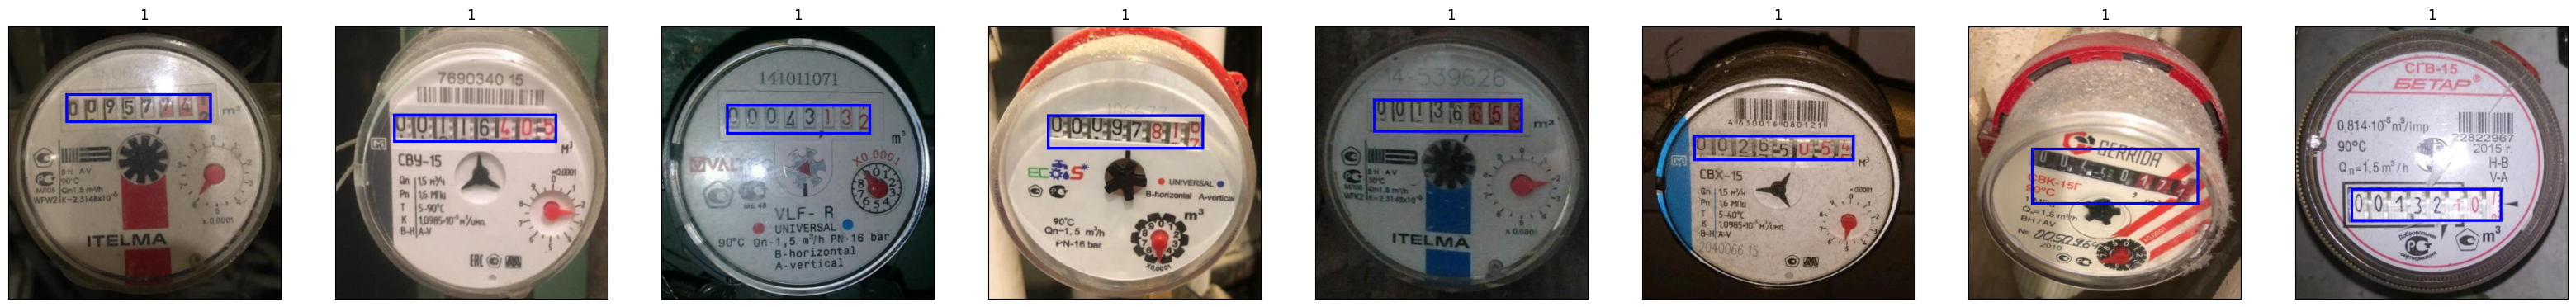

In [9]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, values, bounding_boxes  = next(iter(loader))
img = (img.cpu()*255).type(torch.uint8)
images = [
    draw_bounding_boxes(image, boxes=boxe.unsqueeze(0), width=4, colors=['blue'])
    for image, boxe in zip(img, bounding_boxes)
]
show(images, values)

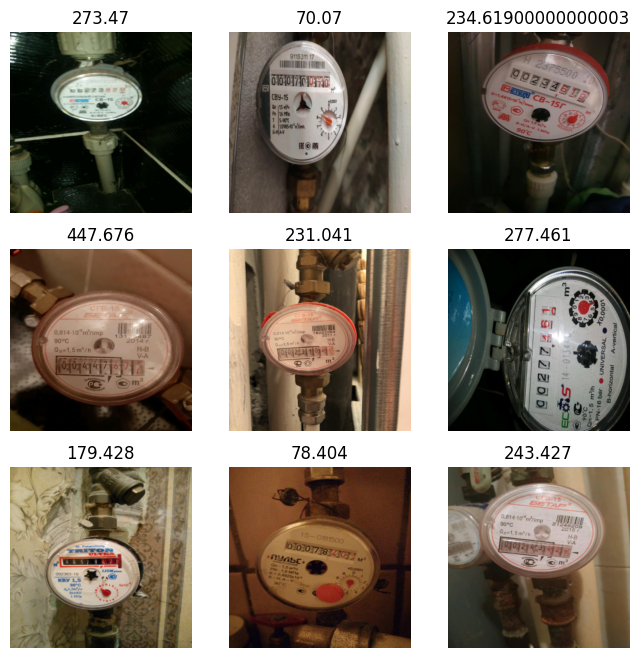

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(waterMeterDataset), size=(1,)).item()
    img, reading, bounding_boxe = waterMeterDataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(reading)
    plt.axis("off")
    plt.imshow(img.squeeze().transpose(0,1).transpose(1,2), cmap="gray")
plt.show()

In [8]:
train_size = int(0.9*len(waterMeterDataset))

In [9]:
def give_model():
    model = fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers = 1)
    num_classes = 2  # 1 class (watermeter) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [10]:
# adapted from https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/
def train(train_dataloader, model, optimizer):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        batch, _, bounding_boxes = data

        batch = list(image.to(DEVICE) for image in batch)

        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE), 'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]
        #it returns during training a dict containing the classification and regression losses.
        loss_dict = model(batch, targets)
        #print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()

        train_loss_list.append(loss_value)

        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss_list

def validate(test_dataloader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(test_dataloader, total=len(test_dataloader))

    for i, data in enumerate(prog_bar):
        batch, _, bounding_boxes = data

        batch = list(image.to(DEVICE) for image in batch)
        #the faster R_CNN model takes as targets a list of dictionnary with boxe and label
        targets = [{'boxes': bounding_boxe.unsqueeze(0).to(DEVICE), 'labels': torch.ones(1, dtype = torch.int64).to(DEVICE)} for bounding_boxe in bounding_boxes]

        with torch.no_grad():
            loss_dict = model(batch, targets)
        #it returns during training a dict containing the classification and regression losses.
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        val_loss_list.append(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list


EPOCH 1 of 10
Training


Loss: 0.0787: 100%|██████████| 140/140 [07:44<00:00,  3.32s/it]


Validating


Loss: 0.0707: 100%|██████████| 16/16 [00:51<00:00,  3.20s/it]


Took 8.603 minutes for epoch 1

EPOCH 2 of 10
Training


Loss: 0.0766: 100%|██████████| 140/140 [02:52<00:00,  1.24s/it]


Validating


Loss: 0.0613: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


Took 3.089 minutes for epoch 2

EPOCH 3 of 10
Training


Loss: 0.0748: 100%|██████████| 140/140 [02:52<00:00,  1.23s/it]


Validating


Loss: 0.0704: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


Took 3.080 minutes for epoch 3

EPOCH 4 of 10
Training


Loss: 0.0829:  68%|██████▊   | 95/140 [01:57<00:55,  1.24s/it]


KeyboardInterrupt: ignored

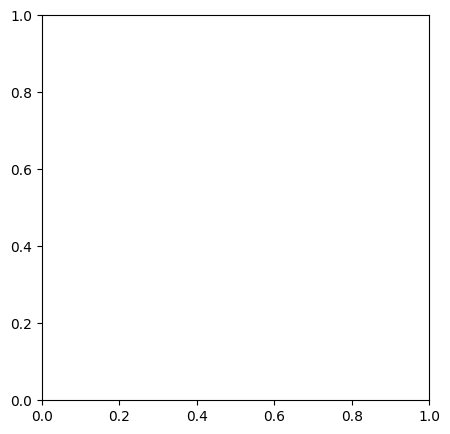

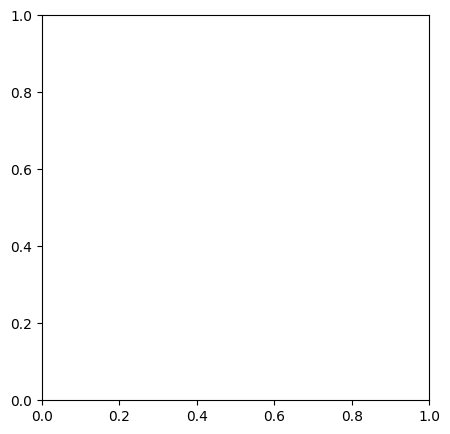

In [14]:
import time

plt.rcParams["figure.figsize"] = (5,5)

if TRAIN_MODE:
    train_set, val_set = torch.utils.data.random_split(waterMeterDataset, [train_size, len(waterMeterDataset) - train_size])
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    # model = give_model()
    # model = model.to(DEVICE)

    params = [p for p in model.parameters() if p.requires_grad]

    # define the optimizer
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.8, weight_decay=0.0005)

    train_itr = 1
    val_itr = 1
    train_loss_list = []
    val_loss_list = []

    # name to save the trained model with
    MODEL_NAME = 'digits_zone_model'

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start the training epochs
    for epoch in range(NB_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NB_EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()

        train_loss = train(train_dataloader, model, optimizer)
        val_loss = validate(test_dataloader, model)

        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + MODEL_NAME + '.pth')
    print('SAVING MODEL COMPLETE...\n')

    train_ax.plot(train_loss_list, color='blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss_list, color='red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    plt.show()

In [15]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + MODEL_NAME + '_upd.pth')
print('SAVING MODEL COMPLETE...\n')

SAVING MODEL COMPLETE...



In [11]:
model = give_model()
model = model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 141MB/s]


In [12]:
import numpy as np
import cv2

# if not TRAIN_MODE:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/OCR_WaterMeters/weights/' + 'digits_zone_model' + '.pth',
                                 map_location=DEVICE))

model = model.to(DEVICE)
# model.eval()
# print('set model to evaluation mode')

set model to evaluation mode


In [ ]:
model.eval()

In [18]:
from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

In [21]:
# train_set, val_set = torch.utils.data.random_split(waterMeterDataset, [train_size, len(waterMeterDataset) - train_size])
# train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

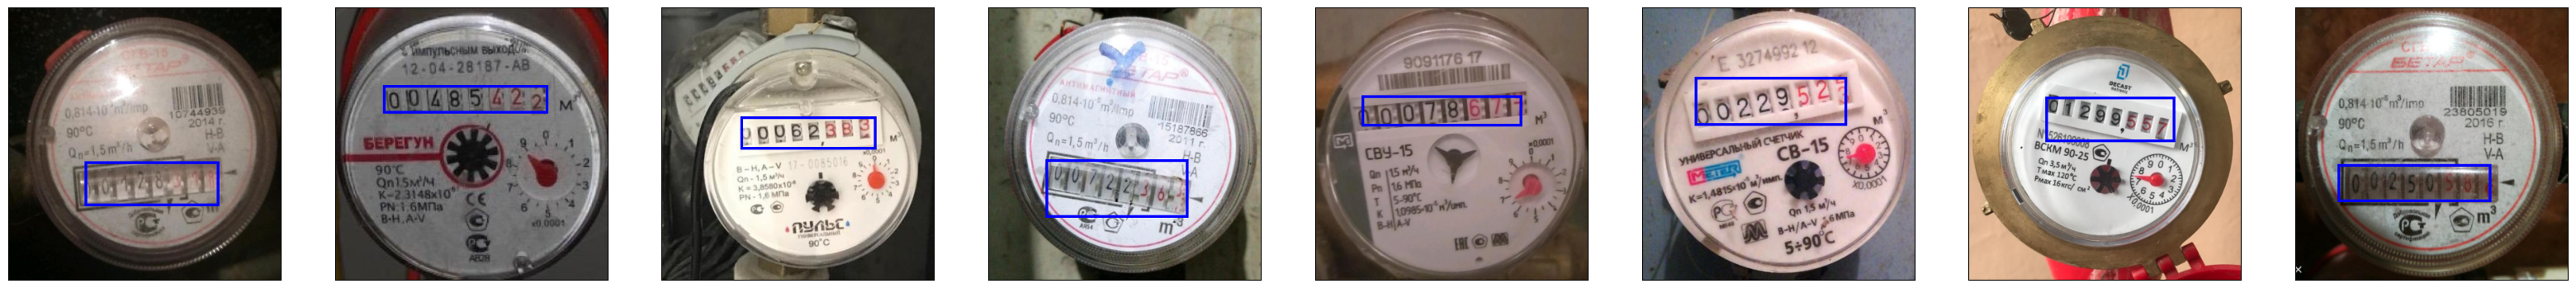

In [22]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

detection_threshold = 0.05


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(loader))
img = img.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(img)

img = (img.cpu()*255).type(torch.uint8)
#images = img.cpu().data.numpy()
#load next operations to cpu
#outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = [
    #draw_bounding_boxes(image, boxes=output['boxes'][output['scores'] > detection_threshold], width=4, colors=['blue'])
    draw_bounding_boxes(image, boxes=output['boxes'][[0]], width=4, colors=['blue'])
    for image, output in zip(img, outputs)
]
show(images)

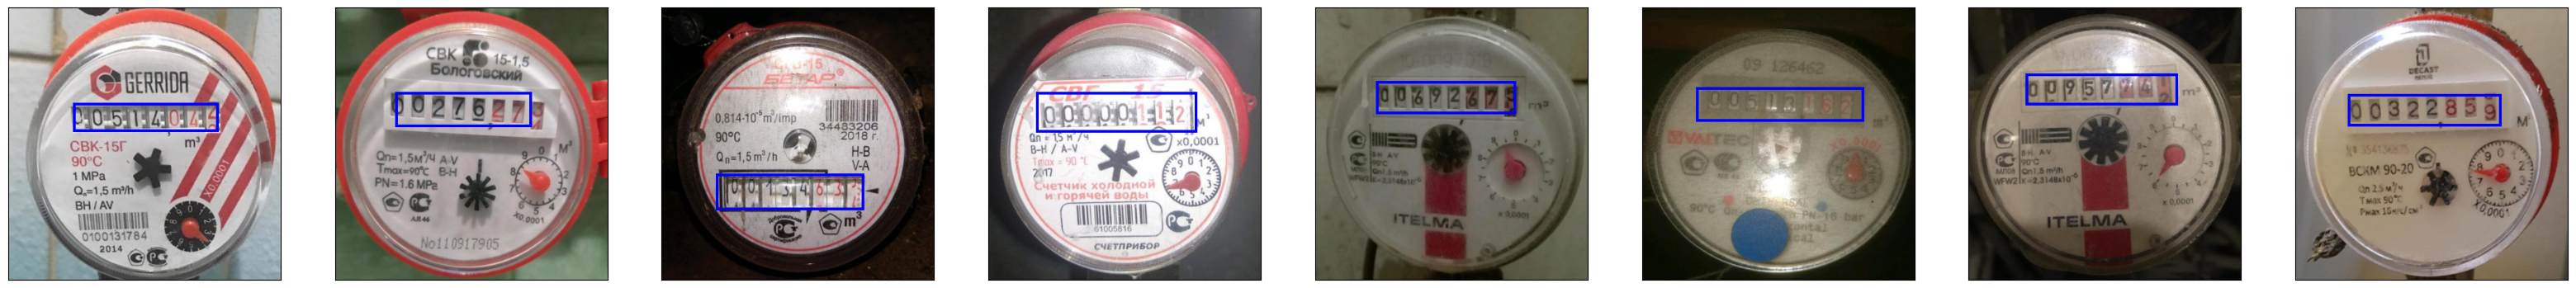

In [20]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (40, 100)

detection_threshold = 0.05


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#loader = DataLoader(waterMeterDataset, batch_size=8, shuffle=True)
img, _, bounding_boxes  = next(iter(test_dataloader))
img = img.to(DEVICE)

model.eval()
with torch.no_grad():
    outputs = model(img)

img = (img.cpu()*255).type(torch.uint8)
#images = img.cpu().data.numpy()
#load next operations to cpu
#outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = [
    #draw_bounding_boxes(image, boxes=output['boxes'][output['scores'] > detection_threshold], width=4, colors=['blue'])
    draw_bounding_boxes(image, boxes=output['boxes'][[0]], width=4, colors=['blue'])
    for image, output in zip(img, outputs)
]
show(images)

In [ ]:
img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230208_160954.jpg')
#img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230301_123204.jpg')
#img_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Pics/IMG_20230301_123225.jpg')
image = read_image(img_path)

In [ ]:
transform_2 = transforms.Compose([
        transforms.ToPILImage(),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize([SIZE,SIZE]),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#ResNet Normalization
    ])

In [ ]:
image = transform_2(image).to(DEVICE)

model.eval()
with torch.no_grad():
    output2 = model(image.unsqueeze(0))

In [ ]:
img = (image.unsqueeze(0).cpu()*255).type(torch.uint8)

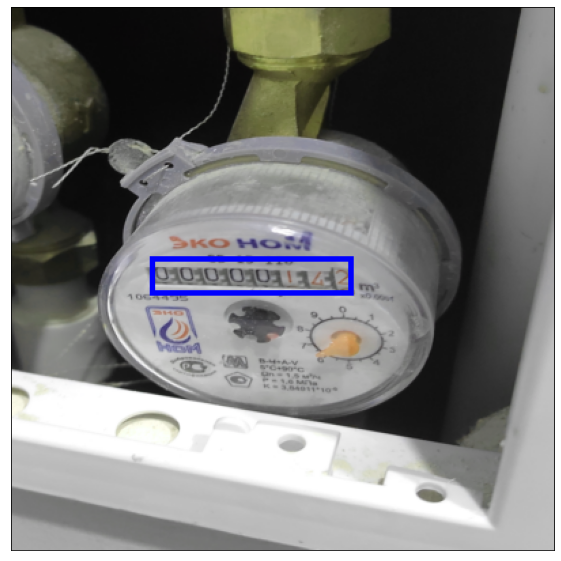

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (10, 10)

images = [
    draw_bounding_boxes(image, boxes=outp['boxes'][[0]], width=4, colors=['blue'])
    for image, outp in zip(img, output2)
]
show(images)

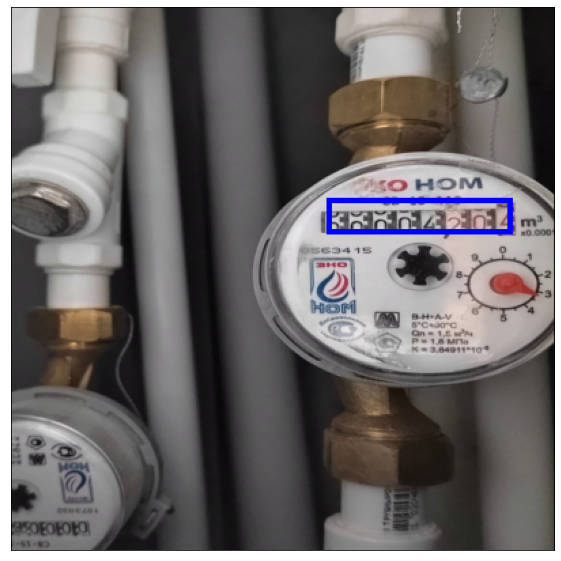

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (10, 10)

images = [
    draw_bounding_boxes(image, boxes=outp['boxes'][[0]], width=4, colors=['blue'])
    for image, outp in zip(img, output2)
]
show(images)